## Anti Money Laundering with Outlier Detection

**Author**: Thodoris Petropoulos

### Scope
The scope of this notebook is to provide an end to end demonstration outlier detection works in DataRobot.

### Background

`Anti Money Laundering` is the process of hiding illicitly obtained money. In this tutorial, we are going to use a historical money transactions dataset and train unsupervised models that detect outliers. 

Keep in mind, that in this dataset, the actual frauds are already depicted in column `SAR` but we are not going to use that information on purpose as in most cases, money laundering goes by undetected and our only way to solve this problem would be unsupervised learning. 

In the end, we are going to use a small subset of the data to evaluate how well the unsupervised approach is working since we do have the labeled data.

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com

#### Import Libraries
To start with, lets import the libraries that will be used in this tutorial

In [150]:
import datarobot as dr
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from sklearn.metrics import f1_score

#### Import Dataset
The target column is `SAR` but for the purposes of this demonstration, we will not use the target column for training, only for evaluating our unsupervised models.

In [3]:
df = pd.read_csv('data/aml.csv')
df.head()

,ALERT,SAR,kycRiskScore,income,tenureMonths,creditScore,state,nbrPurchases90d,avgTxnSize90d,totalSpend90d,...,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,1,0,3,110300.0,5,757,PA,10,153.80,1538.00,...,1,45.82,5,6000,0,3,0,6,1,0
1,1,0,2,107800.0,6,715,NY,22,1.59,34.98,...,1,67.40,0,10000,1,3,0,87,0,0
2,1,0,1,74000.0,13,751,MA,7,57.64,403.48,...,1,450.69,0,10000,0,3,0,6,0,0
3,1,0,0,57700.0,1,659,NJ,14,29.52,413.28,...,1,71.43,0,8000,1,5,0,7,2,0
4,1,0,1,59800.0,3,709,PA,54,115.77,6251.58,...,1,2731.39,3,7000,1,1,0,8,1,0


#### Connect to DataRobot
Connect to DataRobot using your api token and your endpoint. Change input below accordingly.

In [4]:
token = 'YOUR_TOKEN'
endpoint = 'YOUR_DR_URL/api/v2'

dr.Client(token=token, 
          endpoint= endpoint)

#### Clean and Split Dataset

In [14]:
#Split data into train & external_test.
train, external_test = train_test_split(df, test_size=0.15)

#Drop SAR column from Train
train = train.drop('SAR', axis=1)

#### Create a Project
Now that we are connected to DataRobot, we can create a project using the <code>dr.Project.create</code> and `dr.Project.set_target()` methods. Make sure you include `unsupervised_mode = True` to enable autopilot without a target feature.

In [16]:
#First create the project
project = dr.Project.create(project_name='Anti Money Laundering with Outlier Detection',
                            sourcedata= train)

project.set_target(unsupervised_mode = True, worker_count =-1)
project.wait_for_autopilot()

In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 3s)
In progress: 8, queued: 0 (waited: 5s)
In progress: 8, queued: 0 (waited: 7s)
In progress: 8, queued: 0 (waited: 11s)
In progress: 8, queued: 0 (waited: 19s)
In progress: 8, queued: 0 (waited: 32s)
In progress: 2, queued: 0 (waited: 53s)
In progress: 2, queued: 0 (waited: 74s)
In progress: 20, queued: 12 (waited: 95s)
In progress: 19, queued: 9 (waited: 116s)
In progress: 14, queued: 0 (waited: 137s)
In progress: 6, queued: 0 (waited: 158s)
In progress: 1, queued: 0 (waited: 179s)
In progress: 0, queued: 0 (waited: 200s)


#### Train the models on 100% of data
DataRobot will use Synthetic AUC to evaluate how good your models are performing. This is a useful metric to see if the model can detect anomalies but it is not an actual representation of accuracy. We will train all models to 100% and evaluate them all against our labeled test set.

In [144]:
project.unlock_holdout()

for model in project.get_models():
    model.train(100)

#Sleep while waiting for the modeling jobs to complete
while len(project.get_model_jobs()) != 0:
    time.sleep(5)

#Overwriting best_model with newly trained best model
models = []
for model in project.get_models():
    if model.sample_pct == 100:
        models.append(model)

#### Upload Testing Dataset
When working with DataRobot's outlier/anomaly detection, keep in mind that for training data, the most anomalous value will have a score of 1. When we score, if an observation is even more anomalous, it will have a score greater than 1.

The anomalous values are **normalised which means we need to apply a bit of business logic** to get an accurate result. From subject matter experts, we expect that 10% of transactions are fraud. With that in mind, we are  going to assume the the 10% highest anomalous values are the ones that represent fraud.

In [145]:
#Uploading prediction dataset
dataset_from_path = project.upload_dataset(external_test)

#### Function that returns predictions and prediction threshold based on quantile

In [146]:
def get_predictions(model, q=95):
    predict_job = model.request_predictions(dataset_from_path.id)
    predictions = predict_job.get_result_when_complete()
    p = predictions.join(external_test.reset_index())[['prediction','SAR']]
    p_threshold = np.quantile(p['prediction'],0.95)
    
    p['prediction_binary'] = p['prediction'].apply(lambda x: 1 if x >= p_threshold else 0)
    
    return p

#### Plot Confusion Matrix for each model

F1 Score:  0.53007208859048 Model('Mahalanobis Distance Ranked Anomaly Detection with PCA and Calibration')
F1 Score:  0.5251254789966957 Model('Mahalanobis Distance Ranked Anomaly Detection with PCA and Calibration')
F1 Score:  0.6240576708723841 Model('Isolation Forest Anomaly Detection with Calibration')
F1 Score:  0.6685771572164438 Model('Isolation Forest Anomaly Detection with Calibration')
F1 Score:  0.6240576708723841 Model('Anomaly Detection Blender')
F1 Score:  0.6290042804661685 Model('Anomaly Detection Blender')
F1 Score:  0.6388974996537373 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.5993246229034619 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.6537373284350906 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.6042712324972463 Model('Anomaly Detection with Supervised Learning (XGB) and Calibration')
F1 Score:  0.09937560287698714 Model('One-Class SVM An

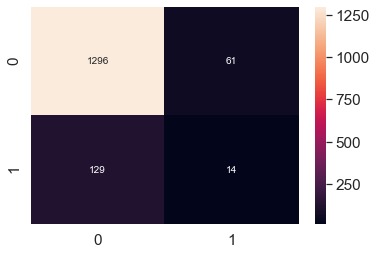

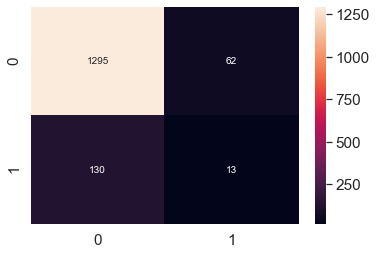

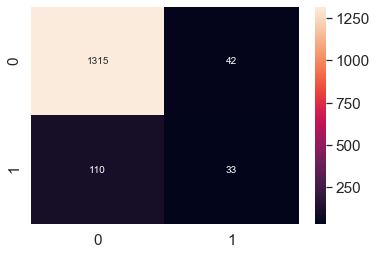

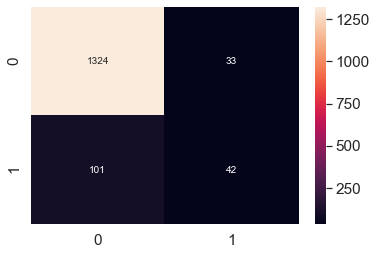

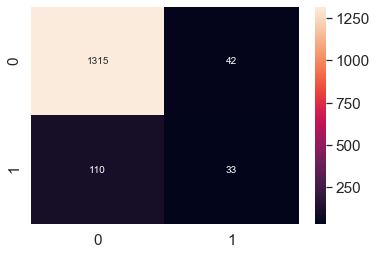

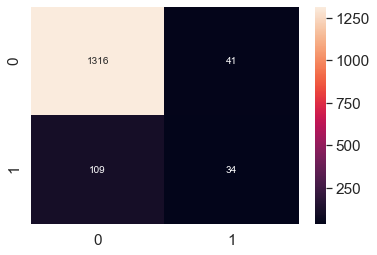

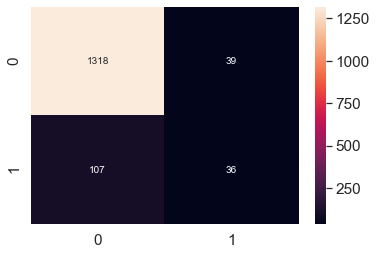

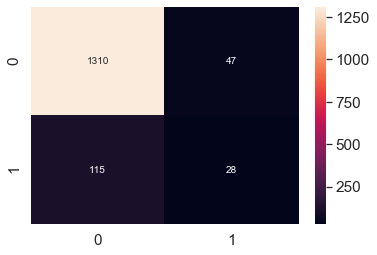

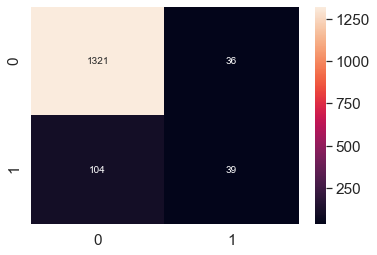

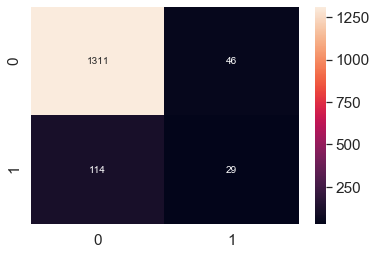

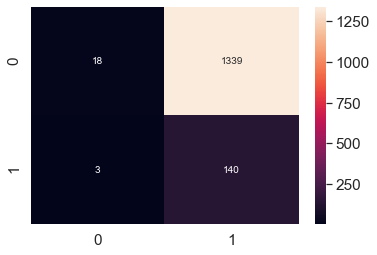

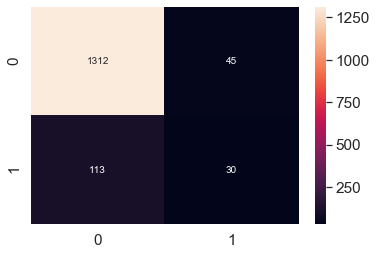

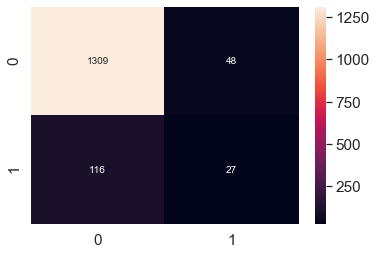

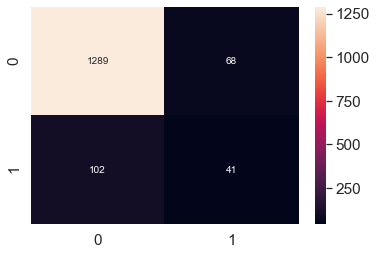

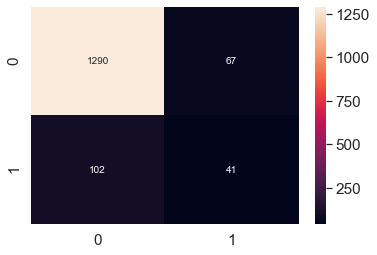

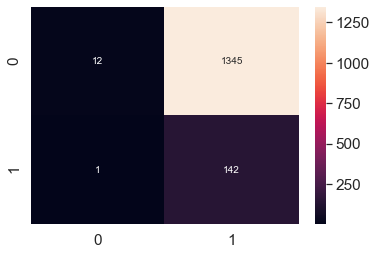

In [153]:
for i, model in enumerate(project.get_models()):
    plt.figure(i) 
    result = get_predictions(model)
    cm=confusion_matrix(result['SAR'],result['prediction_binary'])
    df_cm = pd.DataFrame(cm, range(2), range(2))
    print('F1 Score: ', f1_score(result['SAR'],result['prediction_binary'], average='macro'), model)
    sns.heatmap(df_cm, annot=True,fmt='g')

These are the results for each one of the models based on the particular `prediction_threshold`. Obviously, you are free to experiment with both what model has the best accuracy metric and with what `prediction_threshold` works best for you!